In [ ]:
#DISCLAIMER: Mainly based on, but improved (modular, more logical: https://medium.com/@attyuttam/generative-adversarial-networks-using-pytorch-3ad31cc61ac8)

In [69]:
# import libraries
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from IPython.display import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torchvision
import torch as T
import glob
import cv2
import os

%matplotlib inline

In [2]:
# load data and normalise it
data = FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = Compose(
        [ToTensor(),
         Normalize(
             mean=(0.5,),
             std=(0.5,))
        ]
    )
)

In [3]:
# define function to denormalise data
def de_norm(x):
    
    out = (x + 1) / 2
    
    return out.clamp(0, 1)

In [88]:
def show_dataset_image(datapoint):
    
    img, label = datapoint
    
    img = de_norm(img)
    
    # print image and Label
    print("Label: ", label)
    
    plt.imshow(img[0], cmap = "gray")

def show_image(datapoint, gray = True):
    
    img = de_norm(datapoint)
    
    # print image
    if gray:
        
        plt.imshow(img[0].detach().numpy(), cmap = "gray")
    
    else:
        
        plt.imshow(img[0].detach().numpy())

Label:  9


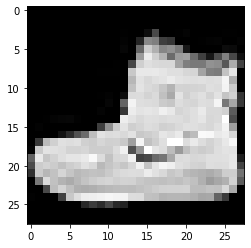

In [5]:
show_dataset_image(data[0])

In [8]:
# split dataset by label

data_dict = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
    5:[],
    6:[],
    7:[],
    8:[],
    9:[]
}

i = 0
for datapoint in data:
    
    img, label = datapoint
    data_dict[label].append(img)
    
    i += 1
    if i % 10000 == 0:
        print("Episode: ", i)

Episode:  10000
Episode:  20000
Episode:  30000
Episode:  40000
Episode:  50000
Episode:  60000


In [9]:
# check data distribution
for key in data_dict.keys():
    
    print(f"{key} has {len(data_dict[key])} entries.")

0 has 6000 entries.
1 has 6000 entries.
2 has 6000 entries.
3 has 6000 entries.
4 has 6000 entries.
5 has 6000 entries.
6 has 6000 entries.
7 has 6000 entries.
8 has 6000 entries.
9 has 6000 entries.


In [10]:
# define data loader for each label
batch_size = 128

data_loader_dict = {}

for key in data_dict.keys():
    
    # get dataloader
    data_loader = DataLoader(data_dict[key], batch_size, shuffle = True)
    
    # append to dict
    data_loader_dict[key] = data_loader

# get rid of data_dict (and clean memory)
data_dict = None

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, image_size, hidden_size):
        
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
        self.optimizer = T.optim.Adam(self.network.parameters(), lr=0.0002)
    
    def forward(self, x):
        
        x = self.network(x)
        
        return x        

In [12]:
class Generator(nn.Module):
    
    def __init__(self, latent_size, hidden_size, image_size):
        
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )
        
        self.optimizer = T.optim.Adam(self.network.parameters(), lr=0.0002)

    
    def forward(self, x):
        
        x = self.network(x)
        
        return x

In [16]:
#Training the discriminator

def reset_grad(generator, discriminator):
    
    generator.optimizer.zero_grad()
    discriminator.optimizer.zero_grad()

def train_discriminator(images, discriminator, generator, criterion):
    
    # Create the labels which are later used as input for the BCE loss
    real_labels = T.ones(batch_size, 1)
    fake_labels = T.zeros(batch_size, 1)
        
    # Loss for real images
    outputs = discriminator(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    fake_images = T.randn(batch_size, latent_size)
    fake_images = generator(fake_images)
    outputs = discriminator(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    
    # Reset gradients
    reset_grad(generator, discriminator)
    
    # Compute gradients
    d_loss.backward()
    
    # Adjust the parameters using backprop
    discriminator.optimizer.step()
    
    return d_loss, real_score, fake_score

In [17]:
def train_generator(generator, discriminator, batch_size, latent_size):
    
    # Generate fake images and calculate loss
    fake_images = T.randn(batch_size, latent_size)
    fake_images = generator(fake_images)
    labels = T.ones(batch_size, 1)
    g_loss = criterion(discriminator(fake_images), labels)

    # Backprop and optimize
    reset_grad(generator, discriminator)
    
    g_loss.backward()
    
    generator.optimizer.step()
    
    return g_loss, fake_images

# Create sample dirs and sub_dirs

In [105]:
latent_size = 64
hidden_size = 256
image_size = 28*28

# get instance of both networks for all classes
GAN_dict = {}
for index in data_loader_dict.keys():
    
    generator = Generator(
        latent_size = latent_size,
        hidden_size = hidden_size,
        image_size = image_size
    )

    discriminator = Discriminator(
        image_size = image_size,
        hidden_size = hidden_size
    )
    
    GAN_dict[index] = {
        "generator": generator,
        "discriminator": discriminator
    }

# get criterion
criterion = nn.BCELoss()

In [106]:
# function to generate and save fake images!
def save_fake_images(index, generator, sample_vectors, sample_dir):
    
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    save_image(de_norm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

def show_fake_images(generator, sample_vectors):
    
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    
    return fake_images

In [107]:
sample_dir = "samples"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
# set number of epochs
num_epochs = 1000 # set lower for faster training progress (300 works also well!) ### 1000 epochs in this config took around 4 hours on a cpu (ryzen 5 3600)

for index in data_loader_dict.keys():
    
    print("Train GAN for index: ", index)
    
    # create sub_dict
    sample_dir = f"samples/{index}"
    
    if not os.path.exists(sample_dir):
        
        os.makedirs(sample_dir)
        
    # Save some real images
    for images in data_loader_dict[index]:
        
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(de_norm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
        break
    
    # save first fake image
    sample_vectors = T.randn(batch_size, latent_size)

    save_fake_images(0, GAN_dict[index]["generator"], sample_vectors, sample_dir)
    
    # train generator and discriminator for data loader of given class
    total_step = len(data_loader_dict[0])
    
    for epoch in range(num_epochs):
        
        print(f"Epoch [{epoch}/{num_epochs}]")
        
        for i, (images) in enumerate(data_loader_dict[index]):

            try: 
                # Load a batch & transform to vectors
                images = images.reshape(batch_size, -1)

                # Train the discriminator and generator
                d_loss, real_score, fake_score = train_discriminator(
                    images, GAN_dict[index]["discriminator"], GAN_dict[index]["generator"], criterion)
                g_loss, fake_images = train_generator(
                    GAN_dict[index]["generator"], GAN_dict[index]["discriminator"], batch_size, latent_size)

                # get step
                if (i+1) % 10 == 0:

                    print(f"\t Step [{i+1}/{total_step}]")
                    
            except:
                
                # needed, because last image batch is always to small!
                continue
                
        # Sample and save images
        sample_vectors = T.randn(batch_size, latent_size)

        save_fake_images(epoch+1, GAN_dict[index]["generator"], sample_vectors, sample_dir)


Train GAN for index:  0
Epoch [0/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [1/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [2/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [3/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [4/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [5/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [6/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [7/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [8/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [9/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [10/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [11/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [12/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47

	 Step [30/47]
	 Step [40/47]
Epoch [108/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [109/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [110/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [111/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [112/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [113/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [114/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [115/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [116/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [117/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [118/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [119/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [120/1000]
	 Step [10/47]
	 Step [20/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [215/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [216/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [217/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [218/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [219/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [220/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [221/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [222/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [223/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [224/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [225/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [226/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [227/1000]

	 Step [40/47]
Epoch [321/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [322/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [323/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [324/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [325/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [326/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [327/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [328/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [329/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [330/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [331/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [332/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [333/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [428/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [429/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [430/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [431/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [432/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [433/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [434/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [435/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [436/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [437/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [438/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [439/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [440/1000]

	 Step [40/47]
Epoch [534/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [535/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [536/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [537/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [538/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [539/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [540/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [541/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [542/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [543/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [544/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [545/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [546/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [641/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [642/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [643/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [644/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [645/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [646/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [647/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [648/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [649/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [650/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [651/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [652/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [653/1000]

	 Step [40/47]
Epoch [747/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [748/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [749/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [750/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [751/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [752/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [753/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [754/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [755/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [756/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [757/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [758/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [759/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [854/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [855/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [856/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [857/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [858/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [859/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [860/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [861/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [862/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [863/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [864/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [865/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [866/1000]

	 Step [40/47]
Epoch [960/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [961/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [962/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [963/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [964/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [965/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [966/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [967/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [968/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [969/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [970/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [971/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [972/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [68/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [69/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [70/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [71/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [72/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [73/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [74/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [75/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [76/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [77/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [78/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [79/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [80/1000]
	 Step [10/4

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [175/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [176/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [177/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [178/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [179/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [180/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [181/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [182/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [183/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [184/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [185/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [186/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [187/1000]

	 Step [40/47]
Epoch [281/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [282/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [283/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [284/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [285/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [286/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [287/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [288/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [289/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [290/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [291/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [292/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [293/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [388/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [389/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [390/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [391/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [392/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [393/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [394/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [395/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [396/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [397/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [398/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [399/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [400/1000]

	 Step [40/47]
Epoch [494/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [495/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [496/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [497/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [498/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [499/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [500/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [501/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [502/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [503/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [504/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [505/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [506/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [601/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [602/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [603/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [604/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [605/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [606/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [607/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [608/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [609/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [610/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [611/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [612/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [613/1000]

	 Step [40/47]
Epoch [707/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [708/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [709/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [710/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [711/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [712/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [713/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [714/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [715/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [716/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [717/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [718/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [719/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [814/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [815/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [816/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [817/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [818/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [819/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [820/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [821/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [822/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [823/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [824/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [825/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [826/1000]

	 Step [40/47]
Epoch [920/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [921/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [922/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [923/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [924/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [925/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [926/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [927/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [928/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [929/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [930/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [931/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [932/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [27/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [28/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [29/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [30/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [31/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [32/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [33/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [34/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [35/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [36/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [37/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [38/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [39/1000]
	 Step [10/47]
	 Step [20/4

	 Step [40/47]
Epoch [134/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [135/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [136/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [137/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [138/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [139/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [140/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [141/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [142/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [143/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [144/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [145/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [146/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [241/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [242/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [243/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [244/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [245/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [246/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [247/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [248/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [249/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [250/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [251/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [252/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [253/1000]

	 Step [40/47]
Epoch [347/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [348/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [349/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [350/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [351/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [352/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [353/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [354/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [355/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [356/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [357/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [358/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [359/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [454/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [455/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [456/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [457/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [458/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [459/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [460/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [461/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [462/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [463/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [464/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [465/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [466/1000]

	 Step [40/47]
Epoch [560/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [561/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [562/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [563/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [564/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [565/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [566/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [567/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [568/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [569/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [570/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [571/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [572/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [667/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [668/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [669/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [670/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [671/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [672/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [673/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [674/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [675/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [676/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [677/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [678/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [679/1000]

	 Step [40/47]
Epoch [773/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [774/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [775/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [776/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [777/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [778/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [779/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [780/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [781/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [782/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [783/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [784/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [785/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [880/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [881/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [882/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [883/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [884/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [885/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [886/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [887/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [888/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [889/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [890/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [891/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [892/1000]

	 Step [40/47]
Epoch [986/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [987/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [988/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [989/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [990/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [991/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [992/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [993/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [994/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [995/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [996/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [997/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [998/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [94/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [95/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [96/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [97/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [98/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [99/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [100/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [101/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [102/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [103/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [104/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [105/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [106/1000]
	 Step [10/47]
	 Ste

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [201/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [202/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [203/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [204/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [205/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [206/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [207/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [208/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [209/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [210/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [211/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [212/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [213/1000]

	 Step [40/47]
Epoch [307/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [308/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [309/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [310/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [311/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [312/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [313/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [314/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [315/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [316/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [317/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [318/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [319/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [414/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [415/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [416/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [417/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [418/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [419/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [420/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [421/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [422/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [423/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [424/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [425/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [426/1000]

	 Step [40/47]
Epoch [520/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [521/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [522/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [523/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [524/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [525/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [526/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [527/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [528/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [529/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [530/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [531/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [532/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [627/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [628/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [629/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [630/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [631/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [632/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [633/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [634/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [635/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [636/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [637/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [638/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [639/1000]

	 Step [40/47]
Epoch [733/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [734/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [735/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [736/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [737/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [738/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [739/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [740/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [741/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [742/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [743/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [744/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [745/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [840/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [841/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [842/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [843/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [844/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [845/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [846/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [847/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [848/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [849/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [850/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [851/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [852/1000]

	 Step [40/47]
Epoch [946/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [947/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [948/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [949/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [950/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [951/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [952/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [953/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [954/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [955/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [956/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [957/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [958/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [40/47]
Epoch [53/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [54/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [55/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [56/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [57/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [58/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [59/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [60/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [61/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [62/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [63/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [64/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [65/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/4

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [161/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [162/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [163/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [164/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [165/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [166/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [167/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [168/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [169/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [170/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [171/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [172/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [173/1000]

	 Step [40/47]
Epoch [267/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [268/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [269/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [270/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [271/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [272/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [273/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [274/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [275/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [276/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [277/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [278/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [279/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [374/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [375/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [376/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [377/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [378/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [379/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [380/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [381/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [382/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [383/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [384/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [385/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [386/1000]

	 Step [40/47]
Epoch [480/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [481/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [482/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [483/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [484/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [485/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [486/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [487/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [488/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [489/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [490/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [491/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [492/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [587/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [588/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [589/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [590/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [591/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [592/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [593/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [594/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [595/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [596/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [597/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [598/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [599/1000]

	 Step [40/47]
Epoch [693/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [694/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [695/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [696/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [697/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [698/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [699/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [700/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [701/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [702/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [703/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [704/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [705/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [800/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [801/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [802/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [803/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [804/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [805/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [806/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [807/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [808/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [809/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [810/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [811/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [812/1000]

	 Step [40/47]
Epoch [906/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [907/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [908/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [909/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [910/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [911/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [912/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [913/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [914/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [915/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [916/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [917/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [918/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [13/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [14/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [15/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [16/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [17/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [18/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [19/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [20/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [21/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [22/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [23/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [24/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [25/1000]
	 Step [10/4

	 Step [40/47]
Epoch [120/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [121/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [122/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [123/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [124/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [125/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [126/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [127/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [128/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [129/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [130/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [131/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [132/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [227/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [228/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [229/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [230/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [231/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [232/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [233/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [234/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [235/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [236/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [237/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [238/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [239/1000]

	 Step [40/47]
Epoch [333/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [334/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [335/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [336/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [337/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [338/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [339/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [340/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [341/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [342/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [343/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [344/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [345/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [440/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [441/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [442/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [443/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [444/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [445/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [446/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [447/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [448/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [449/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [450/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [451/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [452/1000]

	 Step [40/47]
Epoch [546/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [547/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [548/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [549/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [550/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [551/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [552/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [553/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [554/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [555/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [556/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [557/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [558/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [653/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [654/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [655/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [656/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [657/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [658/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [659/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [660/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [661/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [662/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [663/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [664/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [665/1000]

	 Step [40/47]
Epoch [759/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [760/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [761/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [762/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [763/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [764/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [765/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [766/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [767/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [768/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [769/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [770/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [771/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [866/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [867/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [868/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [869/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [870/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [871/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [872/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [873/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [874/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [875/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [876/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [877/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [878/1000]

	 Step [40/47]
Epoch [972/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [973/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [974/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [975/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [976/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [977/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [978/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [979/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [980/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [981/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [982/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [983/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [984/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [80/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [81/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [82/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [83/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [84/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [85/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [86/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [87/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [88/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [89/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [90/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [91/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [92/1000]
	 Step [10/4

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [187/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [188/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [189/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [190/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [191/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [192/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [193/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [194/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [195/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [196/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [197/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [198/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [199/1000]

	 Step [40/47]
Epoch [293/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [294/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [295/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [296/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [297/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [298/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [299/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [300/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [301/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [302/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [303/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [304/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [305/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [400/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [401/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [402/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [403/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [404/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [405/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [406/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [407/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [408/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [409/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [410/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [411/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [412/1000]

	 Step [40/47]
Epoch [506/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [507/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [508/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [509/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [510/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [511/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [512/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [513/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [514/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [515/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [516/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [517/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [518/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [613/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [614/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [615/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [616/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [617/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [618/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [619/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [620/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [621/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [622/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [623/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [624/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [625/1000]

	 Step [40/47]
Epoch [719/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [720/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [721/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [722/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [723/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [724/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [725/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [726/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [727/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [728/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [729/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [730/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [731/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [826/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [827/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [828/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [829/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [830/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [831/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [832/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [833/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [834/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [835/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [836/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [837/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [838/1000]

	 Step [40/47]
Epoch [932/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [933/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [934/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [935/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [936/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [937/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [938/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [939/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [940/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [941/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [942/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [943/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [944/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [30/47]
	 Step [40/47]
Epoch [39/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [40/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [41/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [42/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [43/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [44/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [45/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [46/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [47/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [48/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [49/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [50/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [51/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/4

	 Step [40/47]
Epoch [146/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [147/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [148/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [149/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [150/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [151/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [152/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [153/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [154/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [155/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [156/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [157/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [158/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [253/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [254/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [255/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [256/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [257/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [258/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [259/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [260/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [261/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [262/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [263/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [264/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [265/1000]

	 Step [40/47]
Epoch [359/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [360/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [361/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [362/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [363/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [364/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [365/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [366/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [367/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [368/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [369/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [370/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [371/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [466/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [467/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [468/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [469/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [470/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [471/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [472/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [473/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [474/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [475/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [476/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [477/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [478/1000]

	 Step [40/47]
Epoch [572/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [573/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [574/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [575/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [576/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [577/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [578/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [579/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [580/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [581/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [582/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [583/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [584/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [679/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [680/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [681/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [682/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [683/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [684/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [685/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [686/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [687/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [688/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [689/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [690/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [691/1000]
	 Step [10/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [786/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [787/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [788/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [789/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [790/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [791/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [792/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [793/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [794/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [795/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [796/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [797/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [798/1000]

	 Step [40/47]
Epoch [892/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [893/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [894/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [895/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [896/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [897/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [898/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [899/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [900/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [901/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [902/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [903/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [904/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [999/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Train GAN for index:  8
Epoch [0/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [1/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [2/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [3/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [4/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [5/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [6/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [7/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [8/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [9/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [10/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [11/100

	 Step [40/47]
Epoch [106/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [107/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [108/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [109/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [110/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [111/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [112/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [113/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [114/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [115/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [116/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [117/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [118/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [213/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [214/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [215/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [216/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [217/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [218/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [219/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [220/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [221/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [222/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [223/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [224/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [225/1000]

	 Step [40/47]
Epoch [319/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [320/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [321/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [322/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [323/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [324/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [325/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [326/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [327/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [328/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [329/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [330/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [331/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [426/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [427/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [428/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [429/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [430/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [431/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [432/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [433/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [434/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [435/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [436/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [437/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [438/1000]

	 Step [40/47]
Epoch [532/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [533/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [534/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [535/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [536/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [537/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [538/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [539/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [540/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [541/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [542/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [543/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [544/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [639/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [640/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [641/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [642/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [643/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [644/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [645/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [646/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [647/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [648/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [649/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [650/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [651/1000]

	 Step [40/47]
Epoch [745/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [746/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [747/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [748/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [749/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [750/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [751/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [752/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [753/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [754/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [755/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [756/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [757/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [852/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [853/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [854/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [855/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [856/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [857/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [858/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [859/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [860/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [861/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [862/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [863/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [864/1000]

	 Step [40/47]
Epoch [958/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [959/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [960/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [961/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [962/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [963/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [964/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [965/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [966/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [967/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [968/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [969/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [970/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

Epoch [65/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [66/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [67/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [68/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [69/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [70/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [71/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [72/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [73/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [74/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [75/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [76/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [77/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [78/10

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [173/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [174/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [175/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [176/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [177/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [178/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [179/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [180/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [181/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [182/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [183/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [184/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [185/1000]

	 Step [40/47]
Epoch [279/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [280/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [281/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [282/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [283/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [284/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [285/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [286/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [287/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [288/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [289/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [290/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [291/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [386/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [387/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [388/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [389/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [390/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [391/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [392/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [393/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [394/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [395/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [396/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [397/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [398/1000]

	 Step [40/47]
Epoch [492/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [493/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [494/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [495/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [496/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [497/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [498/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [499/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [500/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [501/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [502/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [503/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [504/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [599/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [600/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [601/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [602/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [603/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [604/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [605/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [606/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [607/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [608/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [609/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [610/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [611/1000]

	 Step [40/47]
Epoch [705/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [706/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [707/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [708/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [709/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [710/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [711/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [712/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [713/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [714/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [715/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [716/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [717/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [812/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [813/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [814/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [815/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [816/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [817/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [818/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [819/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [820/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [821/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [822/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [823/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [824/1000]

	 Step [40/47]
Epoch [918/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [919/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [920/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [921/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [922/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [923/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [924/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [925/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [926/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [927/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [928/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [929/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [930/1000]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]

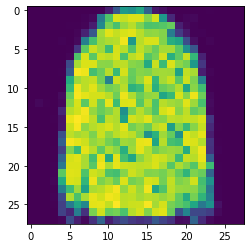

In [103]:
# get an example of each generator by editing index variable
index = 4
    
sample_vectors = T.randn(batch_size, latent_size)
fake_images = show_fake_images(GAN_dict[index]["generator"], sample_vectors)
fake_image = fake_images[0]

# show gan-erated images ## sry :D
show_image(fake_image)
#show_image(fake_image, gray = False)

In [ ]:
for index in data_loader_dict.keys():
    
    img_array = []
    for filename in sorted(glob.glob(f"./samples/{index}/*.png")):
        
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
 
 
    out = cv2.VideoWriter(
        f"gan_training_{index}.avi",
        cv2.VideoWriter_fourcc(*'DIVX'), 15, size
    )

    for i in range(len(img_array)):
        out.write(img_array[i])
        
    out.release()